<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Mod-4-Project---Starter-Notebook" data-toc-modified-id="Mod-4-Project---Starter-Notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Mod 4 Project - Starter Notebook</a></span></li><li><span><a href="#Some-Notes-Before-Starting" data-toc-modified-id="Some-Notes-Before-Starting-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Some Notes Before Starting</a></span><ul class="toc-item"><li><span><a href="#Wide-Format-vs-Long-Format" data-toc-modified-id="Wide-Format-vs-Long-Format-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Wide Format vs Long Format</a></span></li></ul></li><li><span><a href="#Helper-Functions-Provided" data-toc-modified-id="Helper-Functions-Provided-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Helper Functions Provided</a></span></li><li><span><a href="#Step-1:-Load-the-Data/Filtering-for-Chosen-Zipcodes" data-toc-modified-id="Step-1:-Load-the-Data/Filtering-for-Chosen-Zipcodes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Step 1: Load the Data/Filtering for Chosen Zipcodes</a></span></li><li><span><a href="#Step-2:-Data-Preprocessing" data-toc-modified-id="Step-2:-Data-Preprocessing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Step 2: Data Preprocessing</a></span></li><li><span><a href="#Step-3:-EDA-and-Visualization" data-toc-modified-id="Step-3:-EDA-and-Visualization-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Step 3: EDA and Visualization</a></span></li><li><span><a href="#Step-4:-Reshape-from-Wide-to-Long-Format" data-toc-modified-id="Step-4:-Reshape-from-Wide-to-Long-Format-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Step 4: Reshape from Wide to Long Format</a></span></li><li><span><a href="#Step-5:-SARIMAX-Modeling" data-toc-modified-id="Step-5:-SARIMAX-Modeling-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Step 5: SARIMAX Modeling</a></span></li><li><span><a href="#Step-6:-Interpreting-Results" data-toc-modified-id="Step-6:-Interpreting-Results-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Step 6: Interpreting Results</a></span></li></ul></div>

# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import matplotlib
%matplotlib inline

import itertools
import statsmodels.api as sm

In [2]:
data = pd.read_csv('zillow_data.csv')
df = pd.DataFrame(data)

In [3]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df_LA = df[df['City'] == 'Los Angeles']

In [5]:
df_LA.sort_values(by='SizeRank', na_position='first')

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
30,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,31,340600.0,341700.0,343000.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
75,96015,90034,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,76,231300.0,231700.0,232100.0,...,1287500,1310000,1329900,1347200,1360300,1368500,1382700,1398000,1411400,1419100
86,96025,90044,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,87,119500.0,119500.0,119400.0,...,383800,386900,390600,394300,398600,404200,409700,414300,418500,421100
107,96007,90026,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,108,138100.0,138300.0,138300.0,...,883600,895800,907700,919900,932600,947300,962600,973700,975200,972100
133,96047,90066,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,134,241100.0,241000.0,240900.0,...,1435000,1454100,1471100,1473300,1470400,1476200,1490500,1496300,1494000,1489900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7105,96426,91436,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,7106,410400.0,410400.0,410400.0,...,1540000,1558700,1576800,1579800,1577800,1587200,1601400,1616900,1639200,1654200
7578,96371,91345,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,7579,143700.0,143300.0,142900.0,...,494600,498900,503800,508800,513000,516900,520600,523600,525600,526500
7976,95995,90014,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,7977,NaN,NaN,NaN,...,640300,642700,648800,662100,681100,694700,696400,694000,691700,689600
8697,96058,90077,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,8698,762500.0,764100.0,765700.0,...,2968700,2985600,3006100,3032700,3056100,3073600,3101200,3133100,3155800,3159700


The top two in size rank are the West Hollywood and Palms neighborhoods. This makes sense as these are known to be very affluent neighborhoods in the Greater Los Angeles area. A less than 4,000 square foot penthouse apartment at the Edition on Sunset Blvd. in West Hollywood was listed on Zillow at $18.9M in 2020. 

The third ranked zipcode is in a pretty poor neighborhood. This makes me wonder if it is mostly multifamily units being sold here, which would increase the median home sale price for this zipcode. 

Next on the list is the zipcode containing Silverlake and Echo Park, which are popular hipster neighborhoods where some celebritites live and home to some very beautiful and nice homes. 

# Step 2: Data Preprocessing

I just checked and it looks like 'RegionName' is the zipcode and 'RegionID' is extra information that we don't need. So I will go ahead and drop that column.

In [6]:
df_LA = df_LA.drop(['RegionID','SizeRank'], axis=1)

In [7]:
df_LA

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
30,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0,341700.0,343000.0,344400.0,346100.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
75,90034,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,231300.0,231700.0,232100.0,232400.0,232700.0,...,1287500,1310000,1329900,1347200,1360300,1368500,1382700,1398000,1411400,1419100
86,90044,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,119500.0,119500.0,119400.0,119300.0,119200.0,...,383800,386900,390600,394300,398600,404200,409700,414300,418500,421100
107,90026,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,138100.0,138300.0,138300.0,138300.0,138300.0,...,883600,895800,907700,919900,932600,947300,962600,973700,975200,972100
133,90066,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,241100.0,241000.0,240900.0,240800.0,240700.0,...,1435000,1454100,1471100,1473300,1470400,1476200,1490500,1496300,1494000,1489900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7105,91436,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,410400.0,410400.0,410400.0,410700.0,411200.0,...,1540000,1558700,1576800,1579800,1577800,1587200,1601400,1616900,1639200,1654200
7578,91345,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,143700.0,143300.0,142900.0,142500.0,142100.0,...,494600,498900,503800,508800,513000,516900,520600,523600,525600,526500
7976,90014,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,NaN,NaN,NaN,NaN,NaN,...,640300,642700,648800,662100,681100,694700,696400,694000,691700,689600
8697,90077,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,762500.0,764100.0,765700.0,767300.0,769100.0,...,2968700,2985600,3006100,3032700,3056100,3073600,3101200,3133100,3155800,3159700


In [8]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [9]:
get_datetimes(df_LA)

DatetimeIndex(['1996-06-01', '1996-07-01', '1996-08-01', '1996-09-01',
               '1996-10-01', '1996-11-01', '1996-12-01', '1997-01-01',
               '1997-02-01', '1997-03-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=263, freq=None)

# Step 3: EDA and Visualization

In [10]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# Step 4: Reshape from Wide to Long Format

In [11]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted#.groupby('time').aggregate({'value':'mean'})

In [12]:
df_LA_melt = melt_data(df_LA)

In [13]:
df_LA_melt_sort = df_LA_melt.sort_values(by=['RegionName','time','value'])

In [14]:
df_LA_melt_sort['RegionName'].nunique()

95

We can see there are 95 different zipcodes in our dataset for Los Angeles. 

In [15]:
len(df_LA_melt_sort)

24761

And for those 95 zipcodes we have 24,761 datapoints. That's a good amount, giving an average of about 2,500 data points per zip code. Some may have more than others. We can explore that more when we come to it. 

In [16]:
df_LA_melt_sort

,RegionName,City,State,Metro,CountyName,time,value
64,90002,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1996-04-01,110600.0
159,90002,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1996-05-01,110600.0
254,90002,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1996-06-01,110600.0
349,90002,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1996-07-01,110600.0
444,90002,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1996-08-01,110700.0
...,...,...,...,...,...,...,...
24751,91607,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2017-12-01,924800.0
24846,91607,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2018-01-01,930900.0
24941,91607,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2018-02-01,941300.0
25036,91607,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2018-03-01,955500.0


In [17]:
zipcodes = df_LA_melt_sort['RegionName'].unique()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


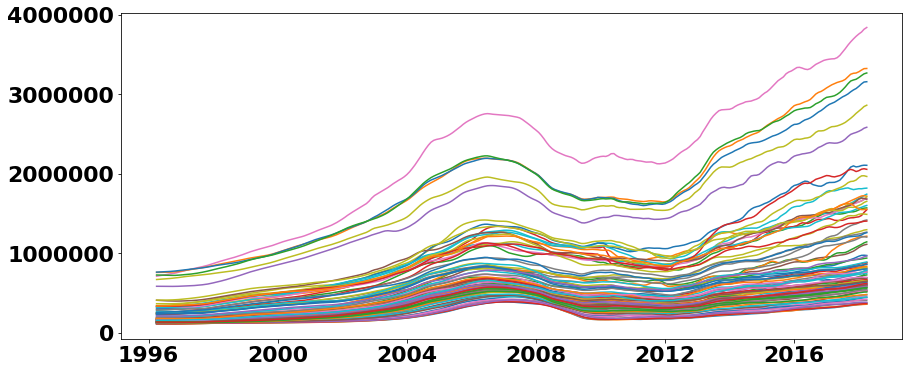

In [18]:
plt.figure(figsize=(14,6))
labels = []
for zipcode in zipcodes:
    df_zip = df_LA_melt_sort[df_LA_melt_sort['RegionName'] == zipcode]
    plt.plot(df_zip['time'],df_zip['value'], label=zipcode)
    labels.append(zipcode)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


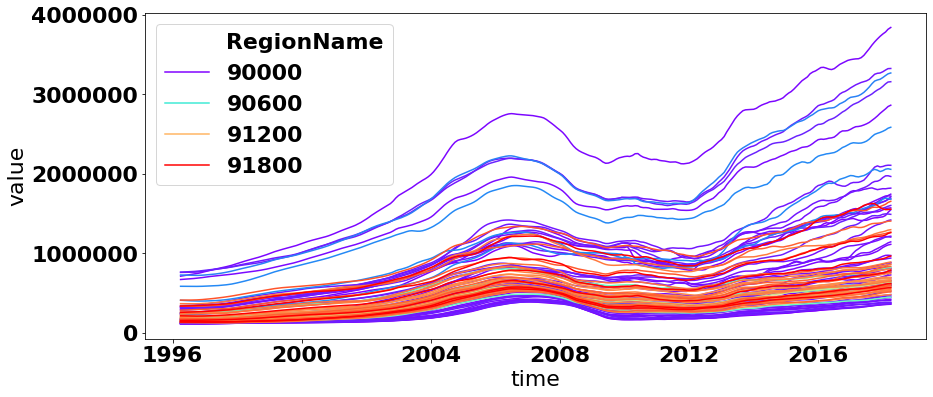

In [19]:
import seaborn as sns
plt.figure(figsize=(14,6))
sns.lineplot(x='time', y='value', data=df_LA_melt_sort, hue='RegionName', palette="rainbow");

**Zipcodes**

We can see a similar trend amongst all of our zipcodes. A few seem to be much higher than others, representing the more affluent neighborhoods. 

This data set represents median housing sale prices, so they could also include multifamily housing units as well, which would sell for a higher price than nearby single family homes. I imagine though overall the median would be representative and not skewed by this as density tends to be mixed (single family homes and multifamily homes), and sometimes in multifamily homes the individual apartments or condos are listed for sale individually. 

**Housing Bubble**

We can see the housing bubble of 2008 in the data here. Home sale values start increasing rapidly in 2004, then max out late 2006/early 2007 and begin to dip to a min in around 2009. Some zipcodes slowly drop even lower for the next couple of years. Prices slowly begin to recover, reaching max bubble values in about 2013, 6 years after the bubble burst. 

Since the market is volatile and bubbles are somewhat unpredictable and do occur, with another one being anticipated in 2020-2022, I am going to leave this data in the data set. 

# Step 5: SARIMAX Modeling

I conducted research and found that there is seasonality in home sales, so I am going to use SARIMA for my ARIMA Modeling, which integrates seasonality in the model. 

**Seasonality**

According to the National Association of Realtors, the number of home sales increases significantly in the spring, with home sales increasing by 34% in February and March. 

Sales continue upward with the busiest home selling months being May through August, accounting for 40% of United States annual home sales volume. 

The slowest months are November through February, with January being the slowest. 

Prices of homes slightly increase during surge months when the demand in the market is higher. Therefore selling homes during these peak times could prove to be advantageous for maximizing profits.

Reference: https://www.nar.realtor/blogs/economists-outlook/seasonality-in-the-housing-market

**Volatility**

A note about market volatility. Since the strategy we are focused on here is buy and hold, if and when there is a housing bubble, it is best to continue to hold during this time. While having a mortgage does create a liability, history shows that during a recession or related housing bubble, the rental market is not as affected as the housing market. 

Reference: https://www.forbes.com/sites/forbesrealestatecouncil/2020/01/02/how-will-a-recession-affect-my-rental-properties/#a4b70b45c70f

In [20]:
WeHo = df_LA_melt_sort[df_LA_melt_sort['RegionName'] == 90046]

In [21]:
WeHo.index = WeHo['time']

In [22]:
to_drop = ['RegionName','City','State','Metro','CountyName','time']
WeHo = WeHo.drop(to_drop, axis=1)
WeHo 

,value
time,
1996-04-01,340600.0
1996-05-01,341700.0
1996-06-01,343000.0
1996-07-01,344400.0
1996-08-01,346100.0
...,...
2017-12-01,1922100.0
2018-01-01,1952400.0
2018-02-01,1974500.0


In [40]:
# Plug the optimal parameter values into a new SARIMAX model
SARIMAX_WeHo = sm.tsa.statespace.SARIMAX(WeHo, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 0, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = SARIMAX_WeHo.fit()

print(output.summary())

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -2512.949
Date:                            Fri, 11 Sep 2020   AIC                           5033.899
Time:                                    16:24:38   BIC                           5047.985
Sample:                                04-01-1996   HQIC                          5039.568
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0098      0.015      0.640      0.522      -0.020       0.040
ma.L1          1.0166      0.011   

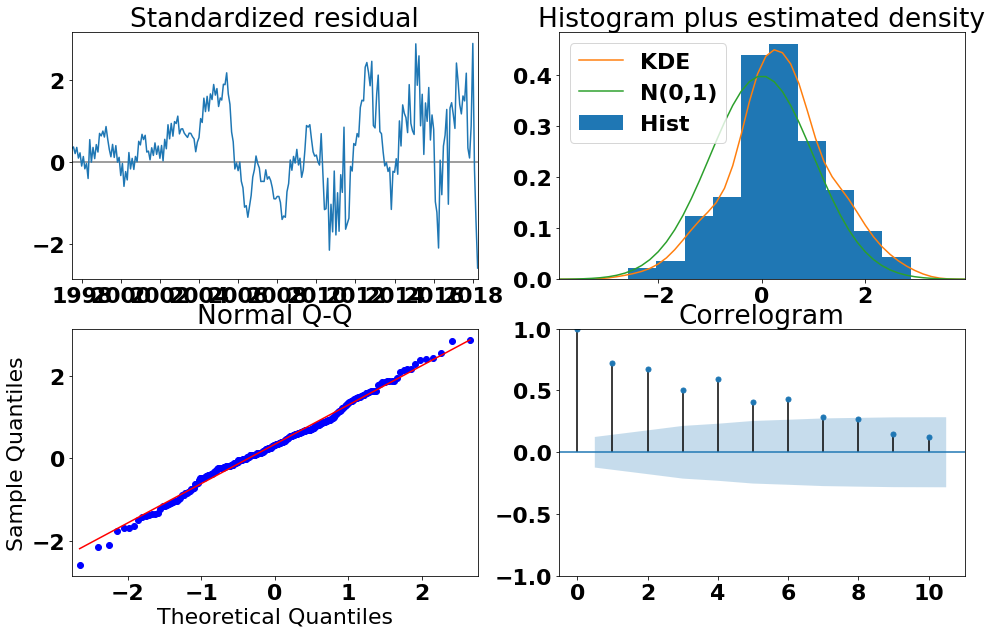

In [41]:
output.plot_diagnostics(figsize=(16,10));

In [39]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_conf = pred.conf_int()

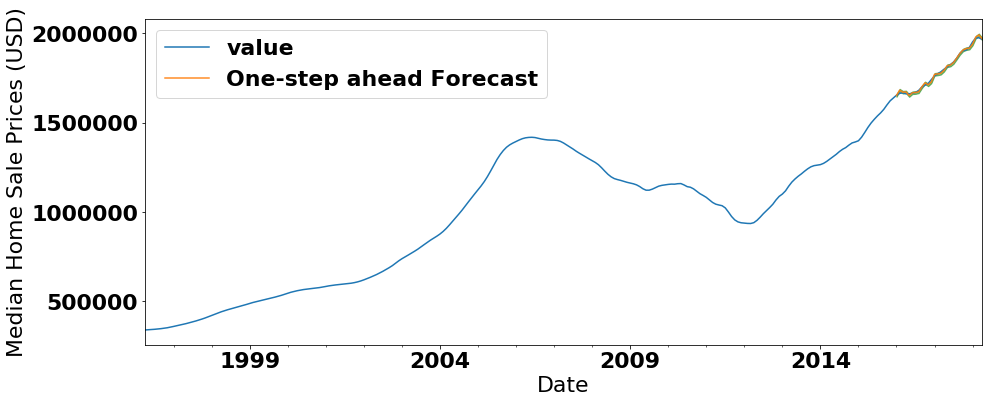

In [26]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = WeHo['1996':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Sale Prices (USD)')
plt.legend()

plt.show()

In [27]:
# # Get the real and predicted values
WeHo_forecasted = pred.predicted_mean
WeHo_truth = WeHo['2016-01-01':]

# # Compute the mean square error
# mse = ((WeHo_forecasted - WeHo_truth) ** 2).mean()
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [28]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

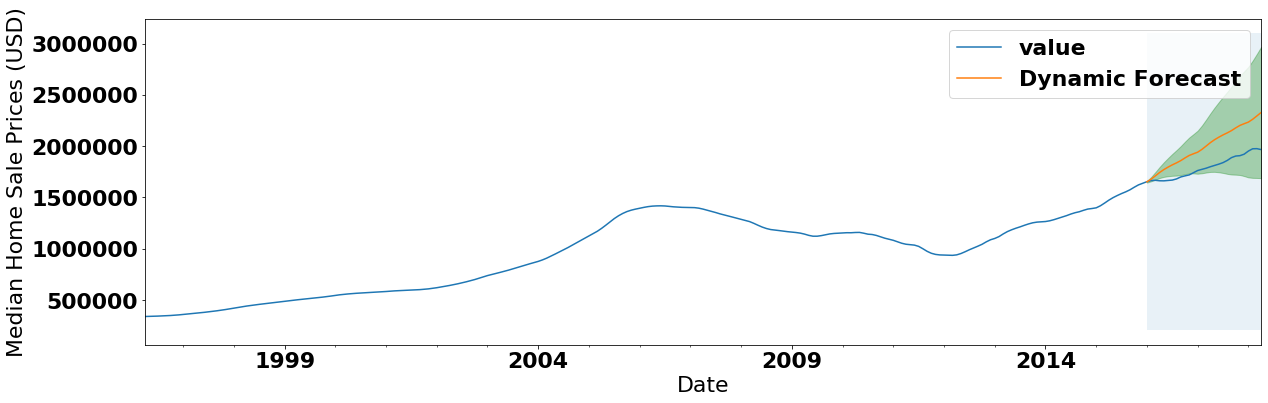

In [29]:
# Plot the dynamic forecast with confidence intervals.

ax = WeHo['1996':].plot(label='observed', figsize=(20, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-01'), WeHo_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Sale Prices (USD)')

plt.legend()
plt.show()

In [30]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [33]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(WeHo,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.bic])
            print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
        except:
            continue

SARIMAX (0, 0, 0) x (0, 0, 0, 12)12 : BIC Calculated =8113.443299026224


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 0) x (0, 0, 1, 12)12 : BIC Calculated =7595.266963003548
SARIMAX (0, 0, 0) x (0, 1, 0, 12)12 : BIC Calculated =6688.0884667503915


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 0) x (0, 1, 1, 12)12 : BIC Calculated =6384.923672269832
SARIMAX (0, 0, 0) x (1, 0, 0, 12)12 : BIC Calculated =6648.447889023032


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : BIC Calculated =6572.305150144114
SARIMAX (0, 0, 0) x (1, 1, 0, 12)12 : BIC Calculated =6264.493057157273


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : BIC Calculated =8469.622922785977


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (0, 0, 0, 12)12 : BIC Calculated =7895.215747094786


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : BIC Calculated =8011.494493018735
SARIMAX (0, 0, 1) x (0, 1, 0, 12)12 : BIC Calculated =6794.33954086683


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (0, 1, 1, 12)12 : BIC Calculated =6160.617239262415


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (1, 0, 0, 12)12 : BIC Calculated =8106.926703802719


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (1, 0, 1, 12)12 : BIC Calculated =7482.8181320037065


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : BIC Calculated =6630.952432774252


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (1, 1, 1, 12)12 : BIC Calculated =8323.236723438991
SARIMAX (0, 1, 0) x (0, 0, 0, 12)12 : BIC Calculated =5719.131563968323
SARIMAX (0, 1, 0) x (0, 0, 1, 12)12 : BIC Calculated =5425.791416408536


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 0) x (0, 1, 0, 12)12 : BIC Calculated =5423.53637060137


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : BIC Calculated =5169.440355321138
SARIMAX (0, 1, 0) x (1, 0, 0, 12)12 : BIC Calculated =5398.466303028724


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 0) x (1, 0, 1, 12)12 : BIC Calculated =5384.145634841664
SARIMAX (0, 1, 0) x (1, 1, 0, 12)12 : BIC Calculated =5190.525403734114


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 0) x (1, 1, 1, 12)12 : BIC Calculated =5173.189632863019
SARIMAX (0, 1, 1) x (0, 0, 0, 12)12 : BIC Calculated =5480.848987569786


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : BIC Calculated =5274.065821663599
SARIMAX (0, 1, 1) x (0, 1, 0, 12)12 : BIC Calculated =5375.149584309725


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (0, 1, 1, 12)12 : BIC Calculated =4957.19915699756


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (1, 0, 0, 12)12 : BIC Calculated =5279.5951207137505


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (1, 0, 1, 12)12 : BIC Calculated =5222.281697352123


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : BIC Calculated =4999.1775287148175


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (1, 1, 1, 12)12 : BIC Calculated =4962.4918077048205
SARIMAX (1, 0, 0) x (0, 0, 0, 12)12 : BIC Calculated =5670.601524667282


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : BIC Calculated =5380.885357868753
SARIMAX (1, 0, 0) x (0, 1, 0, 12)12 : BIC Calculated =5449.325804511568


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (0, 1, 1, 12)12 : BIC Calculated =5242.96872558162
SARIMAX (1, 0, 0) x (1, 0, 0, 12)12 : BIC Calculated =5381.3229949530305


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (1, 0, 1, 12)12 : BIC Calculated =5386.411754736302


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : BIC Calculated =5196.006102857335


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (1, 1, 1, 12)12 : BIC Calculated =7149.789885903355
SARIMAX (1, 0, 1) x (0, 0, 0, 12)12 : BIC Calculated =5432.070487521502


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (0, 0, 1, 12)12 : BIC Calculated =5178.145248194975


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (0, 1, 0, 12)12 : BIC Calculated =5501.527300030016


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (0, 1, 1, 12)12 : BIC Calculated =7513.785847655922


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 0, 0, 12)12 : BIC Calculated =5214.532571505525


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 0, 1, 12)12 : BIC Calculated =5183.5057053757555


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : BIC Calculated =5058.689683221231


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 1, 1, 12)12 : BIC Calculated =6398.565950519913
SARIMAX (1, 1, 0) x (0, 0, 0, 12)12 : BIC Calculated =5099.006343510195


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (0, 0, 1, 12)12 : BIC Calculated =5390.603865232128
SARIMAX (1, 1, 0) x (0, 1, 0, 12)12 : BIC Calculated =4969.351799486595


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (0, 1, 1, 12)12 : BIC Calculated =4731.157469603822
SARIMAX (1, 1, 0) x (1, 0, 0, 12)12 : BIC Calculated =4879.063003588482


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (1, 0, 1, 12)12 : BIC Calculated =4884.413287325449


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (1, 1, 0, 12)12 : BIC Calculated =4721.338413155877


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : BIC Calculated =4726.585538339376
SARIMAX (1, 1, 1) x (0, 0, 0, 12)12 : BIC Calculated =5047.197713917237


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (0, 0, 1, 12)12 : BIC Calculated =5047.9847449512345
SARIMAX (1, 1, 1) x (0, 1, 0, 12)12 : BIC Calculated =4927.463634788085


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : BIC Calculated =4631.849680945653


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 0, 0, 12)12 : BIC Calculated =4770.577444276207


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : BIC Calculated =4755.322922041083


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : BIC Calculated =4652.906176758978


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 1, 1, 12)12 : BIC Calculated =4631.932449909556


In [34]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])
ans_df.loc[ans_df['bic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
bic           4631.85
Name: 59, dtype: object

# Step 6: Interpreting Results